<a href="https://colab.research.google.com/github/geunsu-jo/Hands-On-ML/blob/main/textbook_practice/03_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

사이킷런에서 읽은 데이터셋은 dictionary 구조를 가지고 있다.
- 데이터셋을 설명하는 DESCR 키
- 샘플을 행, 특성(feature)를 열로 구성된 배열 data 키
- 레이블 배열이 있는 target 키

In [8]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)
print(28*28)

(70000, 784)
(70000,)
784


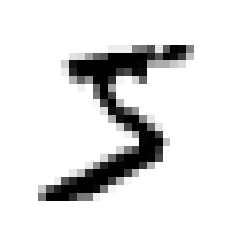

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary") # cmp="gray" 하면 높은 값을 밝게 하면서 색이 반전됨
plt.axis("off")
plt.show()

실제 레이블 확인

In [13]:
y[0]

'5'

정수로 변환

In [17]:
import numpy as np
y = y.astype(np.uint8)
y[0]

5

첫 6만개를 train으로, 나머지를 test로 나누기

In [18]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 이진 분류기 훈련
문제 단순화를 위해, 5만 분류하는 모델

In [27]:
y_train_5 = (y_train == 5) # 5이면 True, 아니면 False
y_test_5 = (y_test == 5)
y_test_5[:3]

array([False, False, False])

사이킷런의 __SGDClassifier__ 클래스를 사용해 Stochastic Gradient Descent 적용(하나의 샘플을 독립적으로 처리)

In [28]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) 
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

- SGDClassifier(혹은 SGDRegressor)는 훈련하는데 무작위성을 가져서 Stocahstic이라 불림 (시계열 데이터엔 비적합)

In [35]:
sgd_clf.predict([some_digit])

array([ True])

## 성능 측정

### 교차검증을 사용한 방법


#### a. 단순 교차검정

In [42]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

#### b. 계층적 샘플링 교차검정

In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
cross_val_score(sgd_clf, X_train, y_train_5, cv=skfolds)

array([0.9669 , 0.91625, 0.96785])

위의 과정을 수동으로 구현하면 다음과 같다

In [45]:
from sklearn.base import clone

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


- 여기서 clone은 데이터까지 복사하는 것이 아니라, 모델만 복사하는 함수다.

#### c. Accuracy 한계
지금까지의 예시에서 무조건 5가 아니라고 예측한 모델을 만들면 꽤 높은 정확도가 나온다.<br>
따라서, 정확도만 살펴볼것이 아니라 다양한 metric으로 모델을 바라볼 필요가 있다. (특히 Imbalanced data)

In [48]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator): 
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

- BaseEstimator는 하이퍼파라미터 튜닝과정이나, 교차검증을 할때 필요한 메소드를 제공해주기 때문에 필수적이로 들어간다고 함

In [51]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3 , scoring="accuracy") #cv=skfolds 넣어도됨

array([0.91125, 0.90855, 0.90915])

- 전부 5가 아니라고 예측하는, 안좋은 모델을 만들어도 90퍼이상의 성능을 보임


### 오차 행렬
__cross_val_predict()__를 이용해 예측값(5인지 아닌지)를 알 수 있다.

In [100]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred[:3]

array([ True, False, False])

- 질문 : cross_val_predict()과정에서 threshold는 튜닝과정을 거쳤는가?

__confusion_matrix()__ 함수를 사용해 오차행렬을 만든다.

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) # label이 항상 먼저 와야한다

array([[53892,   687],
       [ 1891,  3530]])


||Pred - |Pred + |
|---|---|---|
|Real - |TN|FP|
|Real + |FN|TP|

### 정밀도(Precision)와 재현율(Recall)
Precision = TP/(TP+FP) <br>
Recall = TP/(TP+FN)

In [56]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [61]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

추가적으로 Precision과 Recall의 조화 평균인 __F1 Score__도 있음

In [59]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Tradeoff of precision & recall

임계값(threshold)와 비교할 샘플의 점수를 구하려면 __decision_function()__ 메서드를 호출하면 된다.

In [64]:
y_scores = sgd_clf.decision_function([some_digit])
#혹은
y_scores = sgd_clf.decision_function([X[0]])
y_scores

array([2164.22030239])

In [68]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- 임계값이 작을수록, True 예측 수는 증가한다(False 예측 수는 감소)

In [69]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 임계값이 클수록, True 예측 수가 감소한다.(False 예측 수는 증가)

전체 train data에 대해 k-fold를 적용하여 score를 구하고, threshold에 따른 그래프를 그려본다

In [70]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [71]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

- threshold의 수는 y_scores 수와 같거나 적다(y_scores에 중복값이 있을 경우 적아짐)
- precision 과 recall 수는 threshold의 수보다 1개 많다

정밀도와 재현율을 그려보자(코드는 이런게 있다 정도만)

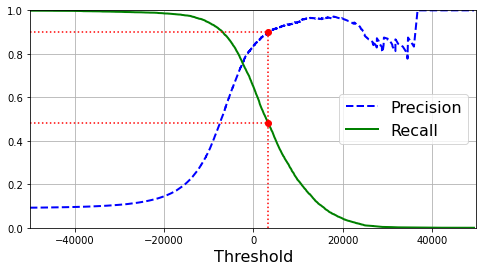

In [74]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

- 정밀도(Precision)은 울퉁불퉁한 곡선을 가지는 반면 재현율(Recall)은 완만하다
- 재현율의 분모는 Truly Positive로, threshold 값에 영향을 받지 않는다.
- 정밀도의 분모는 Pred Positive로, threshold 값에 영향을 받는다
- 따라서, 재현율은 반드시 우하향하지만, 정밀도는 반드시 우상향할 필요는 없다.(threshold가 최대일때 정밀도도 최대값 1을 갖긴함)

np.argmax()는 최댓값의 색인을 반환해준다. 수치가 아니라 bool형이면 처음 나오는 True의 색인을 반환 <br>
np.argmin()는 최솟값의 색인을 반환해준다. 수치가 아니라 bool형이면 처음 나오는 False의 색인을 반환

In [98]:
a = np.array([3,2,1,5,8,78,3])
b = np.array([True,True,False,False,True,False,True,True])
(np.argmax(a), np.argmin(a)), (np.argmax(b), np.argmin(b))

((5, 2), (0, 2))

정밀도가 최소 90%는 달성하는 것이 목표라 가정하고 그때의 임계값을 구해보자 <br>

In [99]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

구해진 임계값을 기준으로 예측값을 구해보자

In [103]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90[:5]

array([False, False, False, False, False])

마지막으로 정밀도와 재현율을 구한다

In [106]:
precision_90 = precision_score(y_train_5, y_train_pred_90)
recall_90 = recall_score(y_train_5, y_train_pred_90)
precision_90, recall_90

(0.9000345901072293, 0.4799852425751706)

- precision 최소 90%가 되는 선에서 recall은 0.4799이다.